## geo_mozambique_1

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt

import earthpy as et
import earthpy.plot as ep
import earthpy.spatial as es

import fiona

import rasterio as rio
from rasterio.plot import show
from rasterio.mask import mask

import cartopy as cp
from shapely.geometry import mapping
from pathlib import Path

### Data understanding

#### Download shapefiles

In [7]:
%%bash 
# in terminal, download and unzip 10m country boundaries shapes from Natural Earth #TODO (Lee) - format long url
wget https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/10m/cultural/ne_10m_admin_0_countries.zip -P ~/Documents/projects_code/geo_mozambique/data/shapes/
unzip ~/Documents/projects_code/geo_mozambique/data/shapes/ne_10m_admin_0_countries.zip -d ~/Documents/projects_code/geo_mozambique/data/shapes/

Archive:  /Users/lee/Documents/projects_code/geo_mozambique/data/shapes/ne_10m_admin_0_countries.zip
  inflating: /Users/lee/Documents/projects_code/geo_mozambique/data/shapes/ne_10m_admin_0_countries.README.html  
 extracting: /Users/lee/Documents/projects_code/geo_mozambique/data/shapes/ne_10m_admin_0_countries.VERSION.txt  
 extracting: /Users/lee/Documents/projects_code/geo_mozambique/data/shapes/ne_10m_admin_0_countries.cpg  
  inflating: /Users/lee/Documents/projects_code/geo_mozambique/data/shapes/ne_10m_admin_0_countries.dbf  
  inflating: /Users/lee/Documents/projects_code/geo_mozambique/data/shapes/ne_10m_admin_0_countries.prj  
  inflating: /Users/lee/Documents/projects_code/geo_mozambique/data/shapes/ne_10m_admin_0_countries.shp  
  inflating: /Users/lee/Documents/projects_code/geo_mozambique/data/shapes/ne_10m_admin_0_countries.shx  


--2019-09-16 21:26:17--  https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/10m/cultural/ne_10m_admin_0_countries.zip
Resolving www.naturalearthdata.com (www.naturalearthdata.com)... 66.147.242.194
Connecting to www.naturalearthdata.com (www.naturalearthdata.com)|66.147.242.194|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: http://naciscdn.org/naturalearth/10m/cultural/ne_10m_admin_0_countries.zip [following]
--2019-09-16 21:26:18--  http://naciscdn.org/naturalearth/10m/cultural/ne_10m_admin_0_countries.zip
Resolving naciscdn.org (naciscdn.org)... 146.201.97.163
Connecting to naciscdn.org (naciscdn.org)|146.201.97.163|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://naciscdn.org/naturalearth/10m/cultural/ne_10m_admin_0_countries.zip [following]
--2019-09-16 21:26:18--  https://naciscdn.org/naturalearth/10m/cultural/ne_10m_admin_0_countries.zip
Connecting to naciscdn.org (n

In [21]:
shapes = '/Users/lee/Documents/projects_code/geo_mozambique/data/shapes/ne_10m_admin_0_countries.shp'
gdf = gpd.read_file(shapes)

In [29]:
# inspect geopandas dataframe
gdf.head(3)

,featurecla,scalerank,LABELRANK,SOVEREIGNT,SOV_A3,ADM0_DIF,LEVEL,TYPE,ADMIN,ADM0_A3,...,NAME_KO,NAME_NL,NAME_PL,NAME_PT,NAME_RU,NAME_SV,NAME_TR,NAME_VI,NAME_ZH,geometry
0,Admin-0 country,5,2,Indonesia,IDN,0,2,Sovereign country,Indonesia,IDN,...,인도네시아,Indonesië,Indonezja,Indonésia,Индонезия,Indonesien,Endonezya,Indonesia,印度尼西亚,(POLYGON ((117.7036079039552 4.163414542001791...
1,Admin-0 country,5,3,Malaysia,MYS,0,2,Sovereign country,Malaysia,MYS,...,말레이시아,Maleisië,Malezja,Malásia,Малайзия,Malaysia,Malezya,Malaysia,马来西亚,(POLYGON ((117.7036079039552 4.163414542001791...
2,Admin-0 country,6,2,Chile,CHL,0,2,Sovereign country,Chile,CHL,...,칠레,Chili,Chile,Chile,Чили,Chile,Şili,Chile,智利,(POLYGON ((-69.51008875199994 -17.506588197999...


In [28]:
# subset shape file to only include country borders of Mozambique
gdf_mozambique = gdf[gdf['ADMIN']=='Mozambique']

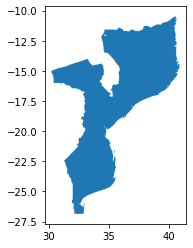

In [32]:
# plot Mozambique shape file
gdf_mozambique.plot()

#### Open file

In [ ]:
with rasterio.open('<filename>', 'w',
                    driver='GTiff',
                    height=Z.shape[0],
                    width=Z.shape[0],
                    count=1,
                    dtype=Z.dtype,
                    crs='proj=latlong', # this is a "proj4" string defining the projection
                    transform=transform,
                    ) as dst:
    dst.write(Z, 1)

### Make raster using shapefile

In [ ]:
with fiona.open("tests/data/box.shp", "r") as shapefile:
    features = [feature["geometry"] for feature in shapefile]